In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import tqdm

In [ ]:
# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

# cvxopt set quiet
import cvxopt
cvxopt.solvers.options['show_progress'] = False

In [ ]:
dataset = [
    {
        "training": np.loadtxt("training_1.txt"),
        "test": np.loadtxt("test_1.txt")
    },
    {
        "training": np.loadtxt("training_2.txt"),
        "test": np.loadtxt("test_2.txt")
    }
]

In [104]:
import cvxopt
import numpy as np

class SVM:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.N = y.shape[0]

    def linear(self, features=None):
        features = features if features is not None else self.x
        return np.dot(features, features.T)

    def rbf(self):
        dist = np.sum((self.x[:, np.newaxis] - self.x[np.newaxis, :]) ** 2, axis=2)
        return np.exp(-self.gamma * dist)

    def calc(self, x):
        assert self.kernel == 'rbf'
        dist = np.zeros((self.N, x.shape[0]))
        for i in range(self.N):
            for j in range(x.shape[0]):
                dist[i, j] = np.sum((self.x[i] - x[j]) ** 2)
        return np.exp(-self.gamma * dist)

    def fit(self, c=None, kernel='linear', gamma=None):
        self.kernel = kernel
        self.gamma = gamma
        self.matrix = self.linear() if kernel == 'linear' else self.rbf()
        self.c = c
        self.alpha = self.solve().flatten()
        self.w = np.dot((self.alpha * self.y).T, self.x)
        self.b = self.calcB()
        return self.w, self.b

    def calcB(self):
        if self.c:
            S = (self.alpha > 1e-4)
            return np.mean(self.y[S] - np.dot(self.x[S], self.w))
        return 0

    def solve(self):
        P = cvxopt.matrix(np.outer(self.y, self.y) * self.matrix)
        q = cvxopt.matrix(-np.ones(self.N))
        A = cvxopt.matrix(self.y, (1, self.N), tc='d')
        b = cvxopt.matrix(0.0)
        G = cvxopt.matrix(np.vstack((-np.eye(self.N), np.eye(self.N))))
        h = cvxopt.matrix(np.hstack((np.zeros(self.N), np.ones(self.N) * self.c)) if self.c else np.zeros(self.N))
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        return np.array(sol['x']).flatten()
    
    def predict(self, x):
        assert self.kernel == 'rbf'
        return np.sign(np.dot(self.alpha * self.y, self.calc(x)) + self.b)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for offset in [0, 1]:
    x_train, y_train = dataset[offset]["training"][:, :2], dataset[offset]["training"][:, 2]
    svm = SVM(x_train, y_train)
    w, b = svm.fit(c=1, kernel='linear')
    print(w, b)
    def plot_decision_boundary_line(x_train, y_train, w, b, ax=ax[offset]):
        ax.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='red')
        ax.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='blue')
        x = np.linspace(np.min(x_train), np.max(x_train), 100)
        y = - (w[0] * x + b) / w[1]
        ax.plot(x, y, color='green')
        ax.legend(['Class 1', 'Class -1', 'Decision Boundary'])
        ax.set_title(f"Dataset {offset + 1}")
    plot_decision_boundary_line(x_train, y_train, w, b)

In [ ]:
for offset in [0, 1]:
    x_train, y_train = dataset[offset]["training"][:, :2], dataset[offset]["training"][:, 2]
    x_test, y_test = dataset[offset]["test"][:, :2], dataset[offset]["test"][:, 2]
    svm = SVM(x_train, y_train)
    w, b = svm.fit(c=1, kernel='linear')
    y_pred = np.sign(np.dot(x_test, w) + b)
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy for dataset {offset + 1}: {accuracy}")

In [ ]:
for c in [0.1, 1, 10]:
    for offset in [0, 1]:
        x_train, y_train = dataset[offset]["training"][:, :2], dataset[offset]["training"][:, 2]
        x_test, y_test = dataset[offset]["test"][:, :2], dataset[offset]["test"][:, 2]
        svm = SVM(x_train, y_train)
        w, b = svm.fit(c=c, kernel='linear')
        y_pred = np.sign(np.dot(x_test, w) + b)
        accuracy = np.mean(y_pred == y_test)
        print(f"Accuracy for dataset {offset + 1} with c={c}: {accuracy}")

In [ ]:
def strimage(file):
    with open(file, 'r') as fidin:
        lines = fidin.readlines()

    size = len(lines)

    grids = []
    y = []

    for it in range(size):
        a = lines[it].strip()
        lena = len(a)
        a = a[3:lena]
        a = a.split(' ')
        xy = np.array([np.fromstring(i, sep=':', dtype=int) for i in a])

        xy = xy.flatten()

        lenxy = len(xy)
        grid = np.zeros(784)
        
        for i in range(1, lenxy, 2):
            if xy[i] <= 0:
                break
            grid[xy[i-1] - 1] = xy[i] * 100 / 255
        
        grid1 = grid.reshape(28, 28)
        grid1 = np.fliplr(np.diag(np.ones(28))).dot(grid1)
        grid1 = np.rot90(grid1, 3)
        
        grids.append(grid1)

        y.append(int(lines[it][:2]))

    return np.array(grids), np.array(y)

In [ ]:
from skimage.feature import local_binary_pattern

def lbp_features(images):
    '''
    input: tensor (N, 28, 28)
    output: tensor (N, 59)
    '''
    N, H, W = images.shape
    lbp_images = np.zeros((N, 59))

    for i in range(N):
        lbp = local_binary_pattern(images[i], P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp, bins=np.arange(60), density=True)
        lbp_images[i] = hist

    return lbp_images

In [ ]:
file = 'train-01-images.svm'

grid, y = strimage(file)

x_train = grid
y_train = y

x_train = lbp_features(x_train)

In [ ]:
def getRandomIndices(x_train, y_train, percentage, seed=0):
    N = x_train.shape[0]
    np.random.seed(seed)
    indices = np.random.permutation(N)
    x_train = x_train[indices]
    y_train = y_train[indices]
    N = int(N * percentage)
    return x_train[:N], y_train[:N]

svm = SVM(*getRandomIndices(x_train, y_train, 0.1))
w, b = svm.fit(c=1, kernel='linear')

In [ ]:
file = 'test-01-images.svm'

grid, y = strimage(file)

x_test = grid
y_test = y

x_test = lbp_features(x_test)

y_pred = np.sign(np.dot(x_test, w) + b)
accuracy = np.mean(y_pred == y_test)

print(f"Accuracy for dataset HandWritten Number: {accuracy}")

In [ ]:
y_pred = np.sign(np.dot(x_test, w) + b)
misclassified = np.where(y_pred != y_test)[0][:10]
y_pred = (np.dot(x_test, w) + b)

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i, idx in enumerate(misclassified):
    ax[i].imshow(grid[idx].reshape(28, 28), cmap='gray')
    ax[i].set_title("Pred: {:.1f}, G.T.: {}".format(y_pred[idx], y_test[idx]))
    ax[i].axis('off')

In [ ]:
for c in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 3000]:
    svm = SVM(*getRandomIndices(x_train, y_train, 0.1, seed=0))
    w, b = svm.fit(c=c, kernel='linear')
    xt, yt = getRandomIndices(x_train, y_train, 0.1, seed=0)
    y_pred = np.sign(np.dot(xt, w) + b)
    train_acc = np.mean(y_pred == yt)
    y_pred = np.sign(np.dot(x_test, w) + b)
    test_acc = np.mean(y_pred == y_test)
    print("Accuracy with c={}: \t{}, \t{}".format(c, train_acc, test_acc))

In [ ]:
x_train = np.loadtxt("training_3.txt")
x_train, y_train = x_train[:, :2], x_train[:, 2]

Text(0.5, 1.0, 'Dataset 3')

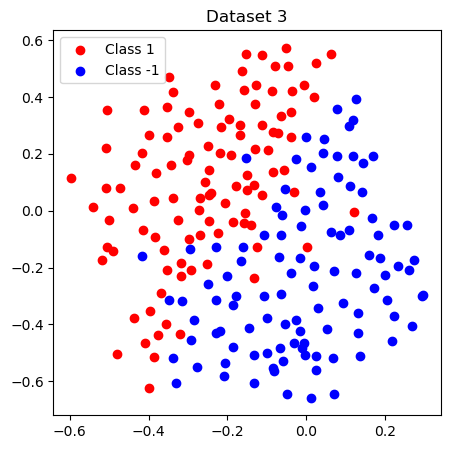

In [90]:
plt.figure(figsize=(5, 5))
plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='red')
plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='blue')

plt.legend(['Class 1', 'Class -1'])
plt.title("Dataset 3")

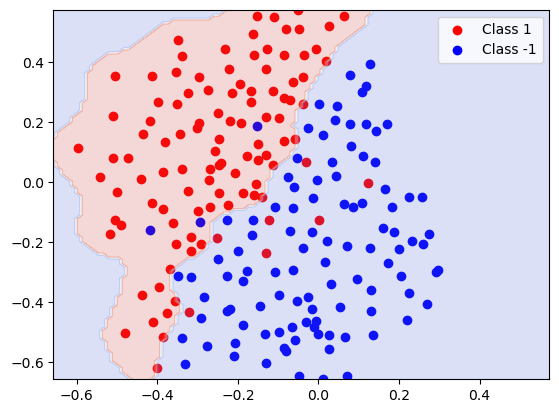

In [ ]:
svm = SVM(x_train, y_train)
svm.fit(c=1, kernel='rbf', gamma=100)

def plot_decision_boundary_rbf(x_train, y_train):
    plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='red')
    plt.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='blue')
    x = np.linspace(np.min(x_train), np.max(x_train), 100)
    y = np.linspace(np.min(x_train), np.max(x_train), 100)
    x, y = np.meshgrid(x, y)
    xy = np.array([x.flatten(), y.flatten()]).T
    z = np.sign(svm.predict(xy)).reshape(100, 100)
    plt.contourf(x, y, z, alpha=0.2, cmap='coolwarm')
    plt.legend(['Class 1', 'Class -1', 'Decision Boundary'])
    
plot_decision_boundary_rbf(x_train, y_train)

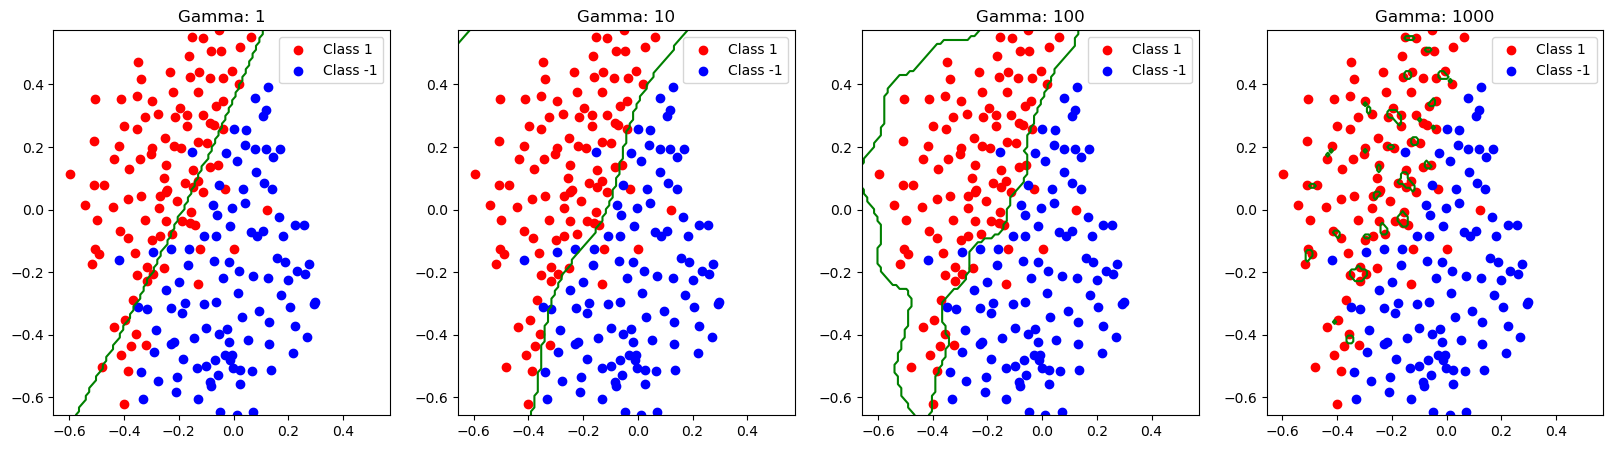

In [108]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for index, gamma in enumerate([1, 10, 100, 1000]):
    svm = SVM(x_train, y_train)
    svm.fit(c=1, kernel='rbf', gamma=gamma)

    def plot_decision_boundary_rbf(x_train, y_train, ax=ax[index]):
        ax.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='red')
        ax.scatter(x_train[y_train == -1][:, 0], x_train[y_train == -1][:, 1], color='blue')
        x = np.linspace(np.min(x_train), np.max(x_train), 100)
        y = np.linspace(np.min(x_train), np.max(x_train), 100)
        x, y = np.meshgrid(x, y)
        xy = np.array([x.flatten(), y.flatten()]).T
        z = np.sign(svm.predict(xy)).reshape(100, 100)
        ax.contour(x, y, z, levels=[0], colors='green')
        ax.legend(['Class 1', 'Class -1', 'Decision Boundary'])
        ax.set_title(f"Gamma: {gamma}")
        
    plot_decision_boundary_rbf(x_train, y_train)